In [1]:
import numpy as np 
import pandas as pd
from google.cloud import bigquery
# https://github.com/SohierDane/BigQuery_Helper
from bq_helper import BigQueryHelper

client = bigquery.Client()
   
query = """
    #standardSQL
    SELECT
        timestamp
    FROM 
         `bigquery-public-data.bitcoin_blockchain.blocks`
    ORDER BY
        timestamp
    """

# This establishes an authenticated session and prepares a reference to the dataset that lives in BigQuery.
bq_assistant = BigQueryHelper("bigquery-public-data", "bitcoin_blockchain")


df = bq_assistant.query_to_pandas_safe(query, max_gb_scanned=1000)
print('Size of dataframe: {} Bytes'.format(int(df.memory_usage(index=True, deep=True).sum())))

# Look at the first 10 headlines
df.head(10)

Using Kaggle's public dataset BigQuery integration.
Using Kaggle's public dataset BigQuery integration.


/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


Size of dataframe: 4324800 Bytes


,timestamp
0,1231469665000
1,1231469744000
2,1231470173000
3,1231470988000
4,1231471428000
5,1231471789000
6,1231472369000
7,1231472743000
8,1231473279000
9,1231473952000


In [2]:
original = df.copy() # save a copy in case we need to restore

In [3]:
from datetime import datetime

df = original.copy()
df = df.sort_values(by=['timestamp'], ascending=True)

# Data Exploration

# Convert timestamp to datetime. it will be easier to read (especially the time-delta's)
ts_col = df['timestamp'].div(1000.0)
df['timestamp'] = ts_col.apply(datetime.fromtimestamp)
print(df.describe())
summary = df.diff().describe()
print(summary)

# From results, we see that the time range is 2009-01-09 -> 2018-09-10
# Also, the greatest block delay was 1 day and 4:47:00! 
# Note that 75th percentile of block times is only 00:12:54. Clearly block times of 02:00:00 are rare. 

                  timestamp
count                540584
unique               540333
top     2012-03-07 02:43:22
freq                      2
first   2009-01-09 02:54:25
last    2018-09-10 13:23:25
                       timestamp
count                     540583
mean   0 days 00:09:24.420523767
std    0 days 00:11:14.035570152
min              0 days 00:00:00
25%              0 days 00:02:43
50%              0 days 00:06:29
75%              0 days 00:12:54
max              1 days 04:47:37


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  # This is added back by InteractiveShellApp.init_path()


2018-09-10 13:23:25


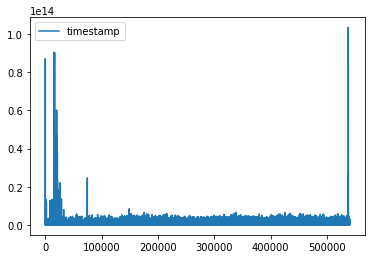

In [4]:
df.diff().plot(kind='line')
maxidx = df.idxmax()
print(df['timestamp'][maxidx['timestamp']])

In [5]:
from scipy.stats import norm
from datetime import datetime, timedelta
import numpy as np

# More data processing

df = df.diff()
df = df.dropna() # since we have a column of diffs, the first entry will need to be ignored

print(df.head())
print(df.describe())
print(df.dtypes)

# convert timedelta type to a float (seconds)

print(df['timestamp'][2].total_seconds())
df['timestamp'] = df['timestamp'].apply(lambda x: x.total_seconds())

float_summary = df.describe()
print(float_summary)

time_threshold = timedelta(hours=2).total_seconds()
print(float_summary["timestamp"][1]) # mean
print(float_summary["timestamp"][2]) # standard dev

        timestamp
1 0 days 00:01:19
2 0 days 00:07:09
3 0 days 00:13:35
4 0 days 00:07:20
5 0 days 00:06:01
                       timestamp
count                     540583
mean   0 days 00:09:24.420523767
std    0 days 00:11:14.035570152
min              0 days 00:00:00
25%              0 days 00:02:43
50%              0 days 00:06:29
75%              0 days 00:12:54
max              1 days 04:47:37
timestamp    timedelta64[ns]
dtype: object
429.0
           timestamp
count  540583.000000
mean      564.420524
std       674.035570
min         0.000000
25%       163.000000
50%       389.000000
75%       774.000000
max    103657.000000
564.4205237678581
674.0355701521313


In [6]:
# Statistical Analysis

# calculate the cumulative density function (CDF)
df_cdf = norm.cdf(time_threshold, float_summary["timestamp"][1], float_summary["timestamp"][2])

# the expected number of blocks w/ block time > 2 hours is P(bt>2hrs) * # of blocks
print((1 - df_cdf) * df.shape[0]) 
print(df.shape[0]) # number of rows

# From the results clearly a block time > 2 hours is extremely rare, since 0 blocks are expected to have this quality. 
# Let's verify that this makes sense. 

print(1- df_cdf) # prob of block time greater than two hours is 1 - CDF. Result = 0% chance. 
print(df.timestamp.quantile(0.99)) # 99th percentile of block times is 2,622 seconds. 2 hours = 7,200 seconds, ~3x greater.

print(len(df[df['timestamp'] > time_threshold])) # the actual number of blocks with block time > 2 hours. 

# Results from above: 141
# Of 540,583 blocks examined only 141 had a block time of >= 2 hours. 



0.0
540583
0.0
2622.0
141
